C:\Users\maximilian.j.mueller\AppData\Local\Temp\ipykernel_24788\3464191200.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['connectionStart'] = data['connectionTime'].dt.floor('T')
C:\Users\maximilian.j.mueller\AppData\Local\Temp\ipykernel_24788\3464191200.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['connectionEnd'] = data['disconnectTime'].dt.floor('T')



Analyse für SiteID=1
Mean Squared Error (MSE) für averageChargingPower (SiteID=1, Ridge): 3.6885


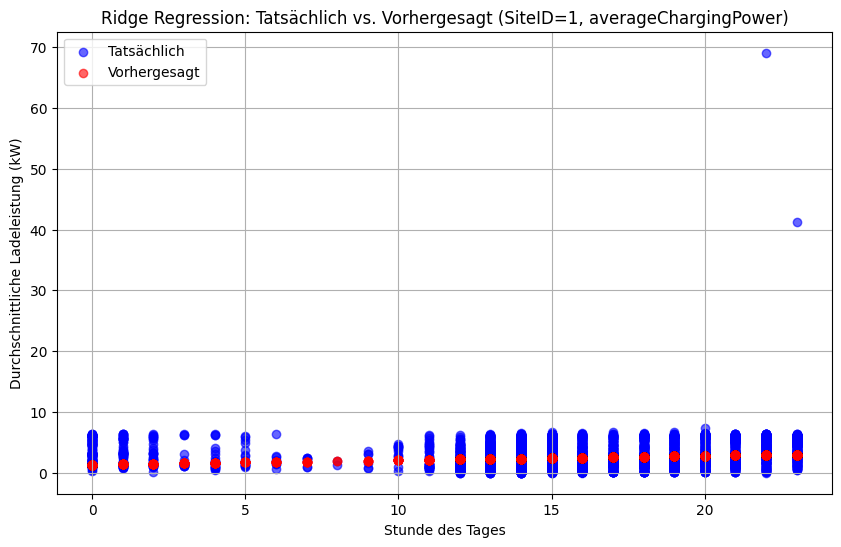

Mean Squared Error (MSE) für siteOccupancy (SiteID=1, Ridge): 866.2998


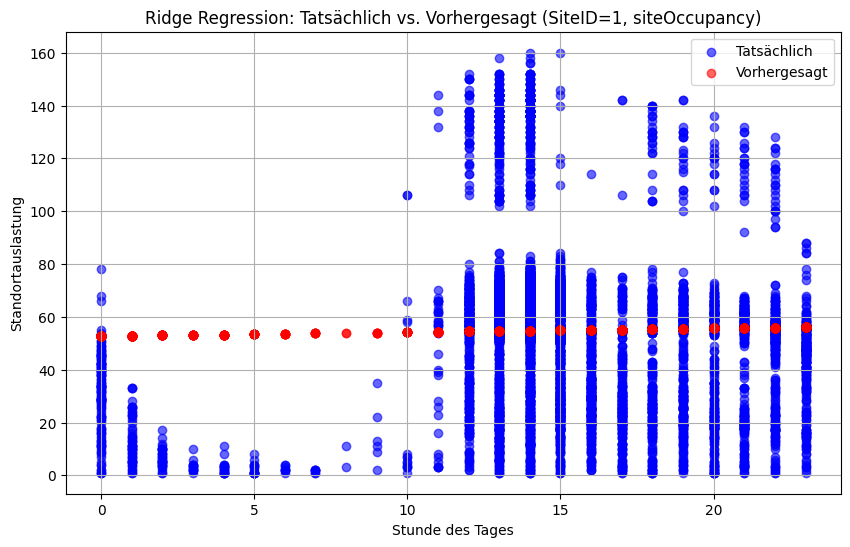


Analyse für SiteID=2
Mean Squared Error (MSE) für averageChargingPower (SiteID=2, Ridge): 32.2646


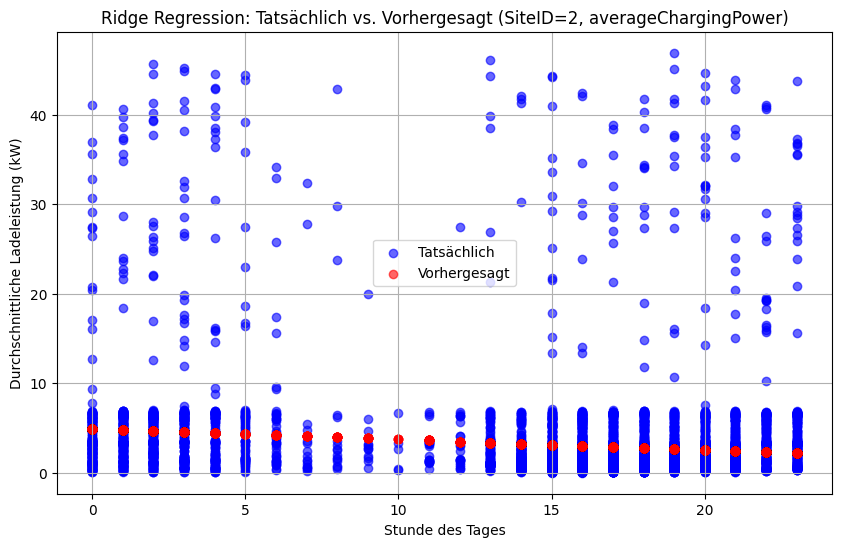

Mean Squared Error (MSE) für siteOccupancy (SiteID=2, Ridge): 433.6451


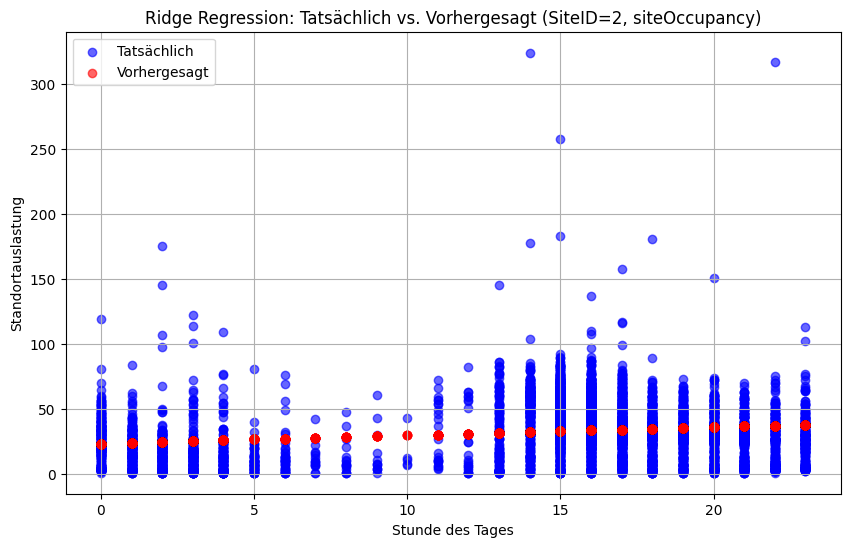

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
data = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

# 2. Feature-Engineering
# Berechnung der durchschnittlichen Ladeleistung
data['averageChargingPower'] = data['kWhDelivered'] / ((data['disconnectTime'] - data['connectionTime']).dt.total_seconds() / 3600)

# Berechnung der Standortauslastung
# Anzahl der gleichzeitigen Ladevorgänge pro Standort und Zeiteinheit
data['connectionStart'] = data['connectionTime'].dt.floor('T')
data['connectionEnd'] = data['disconnectTime'].dt.floor('T')
occupancy = []
for index, row in data.iterrows():
    count = data[(data['siteID'] == row['siteID']) &
                 (data['connectionTime'] <= row['disconnectTime']) &
                 (data['disconnectTime'] >= row['connectionTime'])].shape[0]
    occupancy.append(count)
data['siteOccupancy'] = occupancy

data['hourOfDay'] = data['connectionTime'].dt.hour  # Stunde des Tages aus connectionTime

data = data.dropna(subset=['hourOfDay', 'averageChargingPower', 'siteID', 'siteOccupancy'])

# Analyse für SiteID=1 und SiteID=2
for site in [1, 2]:
    print(f"\nAnalyse für SiteID={site}")
    site_data = data[data['siteID'] == site]

    # Ridge Regression Analyse (1. Zielvariable: averageChargingPower)
    X = site_data[['hourOfDay']]
    y = site_data['averageChargingPower']

    # Daten normalisieren
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Daten aufteilen
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Ridge Regression erstellen und trainieren
    ridge = Ridge(alpha=1.0, random_state=42)
    ridge.fit(X_train, y_train)

    # Vorhersagen und Fehler berechnen
    y_pred = ridge.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE) für averageChargingPower (SiteID={site}, Ridge): {mse:.4f}")

    # Visualisierung der Ergebnisse
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test * scaler.scale_ + scaler.mean_, y_test, alpha=0.6, color="blue", label="Tatsächlich")
    plt.scatter(X_test * scaler.scale_ + scaler.mean_, y_pred, alpha=0.6, color="red", label="Vorhergesagt")
    plt.xlabel("Stunde des Tages")
    plt.ylabel("Durchschnittliche Ladeleistung (kW)")
    plt.title(f"Ridge Regression: Tatsächlich vs. Vorhergesagt (SiteID={site}, averageChargingPower)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Ergebnisse speichern (1. Zielvariable)
    results = pd.DataFrame({"HourOfDay": X_test.flatten() * scaler.scale_[0] + scaler.mean_[0],
                            "Actual": y_test, "Predicted": y_pred})
    results.to_csv(f"ridge_results_site{site}_chargingpower.csv", index=False)

    # Ridge Regression Analyse (2. Zielvariable: siteOccupancy)
    X = site_data[['hourOfDay']]
    y = site_data['siteOccupancy']

    # Daten normalisieren
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Daten aufteilen
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Ridge Regression erstellen und trainieren
    ridge = Ridge(alpha=1.0, random_state=42)
    ridge.fit(X_train, y_train)

    # Vorhersagen und Fehler berechnen
    y_pred = ridge.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE) für siteOccupancy (SiteID={site}, Ridge): {mse:.4f}")

    # Visualisierung der Ergebnisse
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test * scaler.scale_ + scaler.mean_, y_test, alpha=0.6, color="blue", label="Tatsächlich")
    plt.scatter(X_test * scaler.scale_ + scaler.mean_, y_pred, alpha=0.6, color="red", label="Vorhergesagt")
    plt.xlabel("Stunde des Tages")
    plt.ylabel("Standortauslastung")
    plt.title(f"Ridge Regression: Tatsächlich vs. Vorhergesagt (SiteID={site}, siteOccupancy)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Ergebnisse speichern (2. Zielvariable)
    results = pd.DataFrame({"HourOfDay": X_test.flatten() * scaler.scale_[0] + scaler.mean_[0],
                            "Actual": y_test, "Predicted": y_pred})
    results.to_csv(f"ridge_results_site{site}_occupancy.csv", index=False)
